## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:Шпитальник Александр Сергеевич

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import train_utils
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Processing...
Done!


In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

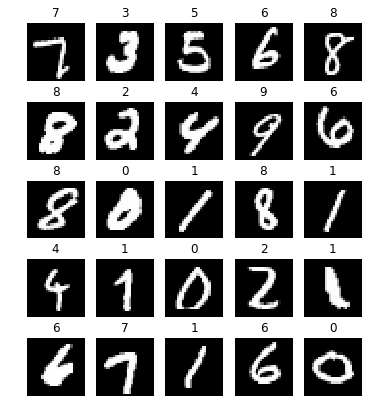

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [50]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)
    
def init_uniform(layer, a, b):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(a, b)

def forward_hook(self, input_, output):
    std = input_[0].std().data[0]
    print 'forward', std

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().data[0]
    print 'backward', std

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [36]:
def new_linear_layer(input_size, output_size, mean, std):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, mean, std)
    return layer

In [47]:
##### Noise #####
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0.0, std=0.1))
layers.append(nn.Tanh())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0.0, std=0.1))
    layers.append(nn.Tanh())
layers.append(new_linear_layer(500, 10, mean=0.0, std=0.1))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)
network

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): Tanh()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): Tanh()
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): Tanh()
  (6): Linear(in_features=500, out_features=500, bias=True)
  (7): Tanh()
  (8): Linear(in_features=500, out_features=500, bias=True)
  (9): Tanh()
  (10): Linear(in_features=500, out_features=500, bias=True)
  (11): Tanh()
  (12): Linear(in_features=500, out_features=500, bias=True)
  (13): Tanh()
  (14): Linear(in_features=500, out_features=500, bias=True)
  (15): Tanh()
  (16): Linear(in_features=500, out_features=500, bias=True)
  (17): Tanh()
  (18): Linear(in_features=500, out_features=500, bias=True)
  (19): Tanh()
  (20): Linear(in_features=500, out_features=500, bias=True)
  (21): Tanh()
  (22): Linear(in_features=500, out_features=10, bias=True)
  (23): LogSoftmax()
)

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [48]:
#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward tensor(1.0118)
forward tensor(0.8495)
forward tensor(0.7860)
forward tensor(0.7720)
forward tensor(0.7676)
forward tensor(0.7645)
forward tensor(0.7659)
forward tensor(0.7638)
forward tensor(0.7662)
forward tensor(0.7645)
forward tensor(0.7630)
forward tensor(0.7644)
backward tensor(0.0034)
backward tensor(0.0006)
backward tensor(0.0007)
backward tensor(0.0009)
backward tensor(0.0011)
backward tensor(0.0013)
backward tensor(0.0016)
backward tensor(0.0019)
backward tensor(0.0023)
backward tensor(0.0028)
backward tensor(0.0032)
backward tensor(0.0032)


/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [49]:
##### HE #####

def new_linear_layer(input_size, output_size, mean, std):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, mean, std)
    return layer

layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./500)))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./500)))
    layers.append(nn.ReLU())
layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./10)))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)
network

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): ReLU()
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): ReLU()
  (6): Linear(in_features=500, out_features=500, bias=True)
  (7): ReLU()
  (8): Linear(in_features=500, out_features=500, bias=True)
  (9): ReLU()
  (10): Linear(in_features=500, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=500, bias=True)
  (13): ReLU()
  (14): Linear(in_features=500, out_features=500, bias=True)
  (15): ReLU()
  (16): Linear(in_features=500, out_features=500, bias=True)
  (17): ReLU()
  (18): Linear(in_features=500, out_features=500, bias=True)
  (19): ReLU()
  (20): Linear(in_features=500, out_features=500, bias=True)
  (21): ReLU()
  (22): Linear(in_features=500, out_features=10, bias=True)
  (23): LogSoftmax()
)

In [46]:
#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward tensor(1.0118)
forward tensor(1.0433)
forward tensor(1.0287)
forward tensor(1.0168)
forward tensor(0.9855)
forward tensor(0.9628)
forward tensor(0.9453)
forward tensor(0.9070)
forward tensor(0.9438)
forward tensor(1.0382)
forward tensor(1.0752)
forward tensor(1.0947)
backward tensor(0.0040)
backward tensor(0.0039)
backward tensor(0.0039)
backward tensor(0.0039)
backward tensor(0.0041)
backward tensor(0.0039)
backward tensor(0.0040)
backward tensor(0.0040)
backward tensor(0.0041)
backward tensor(0.0040)
backward tensor(0.0040)
backward tensor(0.0040)


/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [78]:
### Xavier 
def new_linear_layer(input_size, output_size, a, b):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_uniform(layer, a, b)
    return layer

layers = []
layers.append(new_linear_layer(784, 500, a= -np.sqrt(6./1284)*5/3, b=np.sqrt(6./1284)*5/3))
layers.append(nn.Tanh())
for i in range(10):
    layers.append(new_linear_layer(500, 500, a=-np.sqrt(6./1000)*5/3, b=np.sqrt(6./1000)*5/3))
    layers.append(nn.Tanh())
layers.append(new_linear_layer(500, 10, a=-np.sqrt(6./510)*5/3, b=np.sqrt(6./510)*5/3))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)
network

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): Tanh()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): Tanh()
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): Tanh()
  (6): Linear(in_features=500, out_features=500, bias=True)
  (7): Tanh()
  (8): Linear(in_features=500, out_features=500, bias=True)
  (9): Tanh()
  (10): Linear(in_features=500, out_features=500, bias=True)
  (11): Tanh()
  (12): Linear(in_features=500, out_features=500, bias=True)
  (13): Tanh()
  (14): Linear(in_features=500, out_features=500, bias=True)
  (15): Tanh()
  (16): Linear(in_features=500, out_features=500, bias=True)
  (17): Tanh()
  (18): Linear(in_features=500, out_features=500, bias=True)
  (19): Tanh()
  (20): Linear(in_features=500, out_features=500, bias=True)
  (21): Tanh()
  (22): Linear(in_features=500, out_features=10, bias=True)
  (23): LogSoftmax()
)

In [79]:
#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward tensor(1.0118)
forward tensor(0.7773)
forward tensor(0.6973)
forward tensor(0.6644)
forward tensor(0.6547)
forward tensor(0.6500)
forward tensor(0.6492)
forward tensor(0.6508)
forward tensor(0.6503)
forward tensor(0.6464)
forward tensor(0.6475)
forward tensor(0.6509)
backward tensor(0.0035)
backward tensor(0.0008)
backward tensor(0.0008)
backward tensor(0.0009)
backward tensor(0.0010)
backward tensor(0.0011)
backward tensor(0.0012)
backward tensor(0.0014)
backward tensor(0.0015)
backward tensor(0.0016)
backward tensor(0.0016)
backward tensor(0.0014)


/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

Epoch 9... (Train/Test) NLL: 0.026/0.102	Accuracy: 0.991/0.974

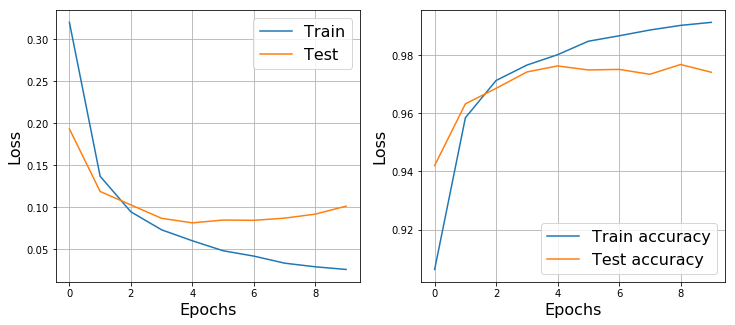

In [163]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

In [54]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=mean, std=std), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros(self.weight.size())+(1-self.p)
            mask = torch.bernoulli(mask)
        else:
            mask = torch.ones(self.weight.size())*self.p
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(x, self.weight*mask)+self.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

Epoch 9... (Train/Test) NLL: 0.123/0.084	Accuracy: 0.963/0.977

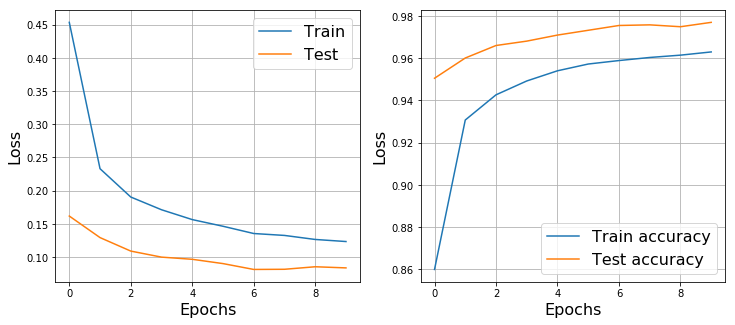

In [57]:
##DropOut
network = nn.Sequential(nn.Linear(784, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

train_utils.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  losses.append(loss_batch.data[0])
train_utils.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  losses.append(loss_batch.data[0])


Epoch 9... (Train/Test) NLL: 0.077/0.063	Accuracy: 0.975/0.981

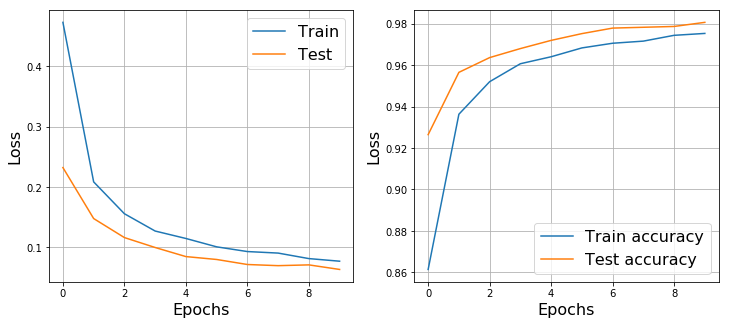

In [55]:
##DropConnect
network = nn.Sequential(DropConnect(784, 200, p=0.5),
                        nn.ReLU(),
                        DropConnect(200, 200, p=0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

<i> 2.3 Сделайте выводы по третьей части </i>

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [69]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        E = x.mean(dim = 1).reshape(x.shape[0],1)
        S = x.std(dim = 1).reshape(x.shape[0],1)
        output = (x - E)/S
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.017/0.074	Accuracy: 0.994/0.979

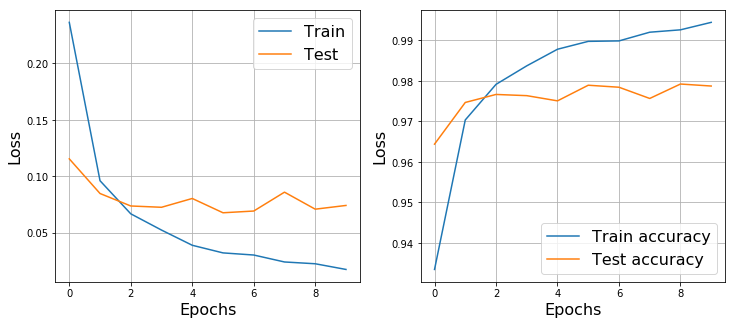

In [70]:
##Layer normalization
network = nn.Sequential(nn.Linear(784, 200),
                        LayerNormalization(),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        LayerNormalization(),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

Epoch 9... (Train/Test) NLL: 0.066/0.090	Accuracy: 0.994/0.984

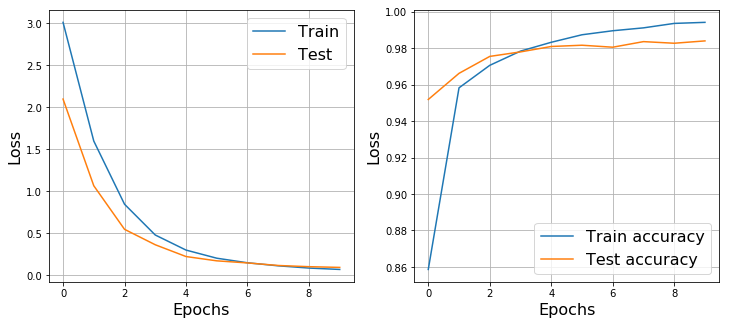

In [73]:
##Layer normalization
network = nn.Sequential(nn.Linear(784, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: